In [5]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 순환 신경망(RNN)
- <b>RNN: Recurrent Neural Network의 약자</b>
- <b>RNN의 목적</b>
  - 미래 예측
  - 과거의 문맥을 학습하여 추론 또는 다음에 발생 가능한 현상을 예측
- <b>RNN 사용 예</b>
  - 시계열(time series)데이터를 이용한 시계열 추이 예측
    - 주식 가격 데이터를 통해 향후 주가 예측
  - 자율주행 시스템
    - 운전센서 시계열 측정치를 이용하여, 자동차의 이동경로를 예측하여 사고 회피
  - 자연어 처리(NLP: Natural Language Processing)
    - 문자열 입력을 통한 감성 분석(sentiment analysis)
      - 영화 리뷰의 감성 분석 및 평점 예측
  - 검색 엔진 연관 검색어
  - Audio
    - 애플 시리와 구글 어시스턴트
  - 마젠타 프로젝트
    - Magenta is a research project exploring the role of machine learning in the process of <b>creating art and music</b>. Primarily this involves developing new deep learning and reinforcement learning algorithms for <b>generating songs, images, drawings, and other materials</b>. But it's also an exploration in building <b>smart tools and interfaces that allow artists and musicians to extend (not replace!) their processes using these models</b>. Magenta was started by some <b>researchers and engineers from the Google Brain team</b>. We use <b>TensorFlow</b> and release our models and tools in open source on this GitHub.(https://github.com/tensorflow/magenta/blob/master/README.md)
    - https://cdn2.vox-cdn.com/uploads/chorus_asset/file/6577761/Google_-_Magenta_music_sample.0.mp3
  - 이미지 캡셔닝
    - O. Vinylas, A. Toshev, S. Bengio and D. Erhan, "Show and Tell: A Neural Image Caption Generator," arXiv:1411.4555v2 [cs.CV], 20, Apr, 2015.
<img src="./img/chap14-1/img/01-D957E9D1-188F-44E2-87DD-FA432CCB92E9.png" width="90%"></img>
- <b>RNN의 특징</b>
  - 시퀀스 데이터의 모델링에 사용된다.
    - 시퀀스 데이터: 순서가 있는 데이터(대부분에서 시간(타임 스텝)에 따른 순서를 갖는 데이터). 시퀀스 데이터의 길이는 dynamic할 수 있음.
      - 예) 음성, 동영상, 텍스트, 주가, 기온, 뇌파, 회사 실적 등
  - RNN은 고정 길이 입력/출력으로 제한되는 것이 아닌, 임의의 길이를 가진 입력/출력
- <b>발표 순서</b>
  - 14.1 순환뉴런
  - 14.2 텐서플로로 기본 RNN 구성하기
  - 14.3 RNN 훈련하기
  - 14.4 심층 RNN

## 14.1 순환 뉴런
- 피드포워드 신경망
  - 입력층에서 출력층 한 방향으로만 흐르는 피드포워드 신경망
<img src="./img/chap14-1/img/02-1_uJkug08zddT_gAB1RQBj7w.png" width="30%"></img>

- 순환 신경망
  - 입력층에서 출력층으로 향하는 것 뿐만 아니라, 자신에게도 출력을 보내는 연결도 존재함(recurrent한 특성)
  - 과거의 정보가 보존될 수 있게 한다.
  - 시간에 따라 펼쳐진 네트워크(unrolled RNN)
    - 순환 뉴런을 시간을 축으로하여 펼쳐 표현한 네트워크
    - 동일한 네트워크의 복사본을 시간에 따라 펼친 것으로 이해할 수 있음
<img src="./img/chap14-1/img/03-1_DIoRyfXnAGCVW8s9qUSGnA.png" width="60%"></img>

  - 타임 스텝 <code>t</code>에서의 하나의 순환 뉴런은, 현재 입력 벡터인 <code>x(t)</code>와 이전 타임 스텝의 출력 벡터인 <code>y(t-1)</code>을 입력으로 받는다.
  - 앞서 나온 입력의 결과가 다음 결과에 영향을 준다.
    - "오늘 주가가 몇인가?"
      - "오늘" -> "주가가" -> "몇인가?"
      - 새로 등장하는 단어는 이전 단어에 종속적이다.
<br><br>


- 수식
  - 입력과 출력이 벡터일 경우
    - 타임 스텝 <code>t</code>에서의 하나의 순환 뉴런은, 현재 입력 벡터인 <code>x(t)</code>와 이전 타임 스텝의 출력 벡터인 <code>y(t-1)</code>을 입력으로 받으므로,
      - 현재 입력 벡터인 <code>x(t)</code>를 위한 가중치와 --> <code><b>wx</b></code>
      - 이전 타임 스텝의 출력 벡터인 <code>y(t-1)</code>을 위한 가중치를 가진다. --> <code><b>wy</b></code>
    - 하나가 아닌 여러 개의 뉴런을 고려하면, 가중치 벡터는 가중치 행렬이 됨 --> <code><b>Wx</b></code>, <code><b>Wy</b></code>
<img src="./img/chap14-1/img/10-eq.png" width="40%"></img>
(<b>식 14-1</b>, 하나의 샘플에 대한 순환 층의 출력 수식)

    - <code><b>x(t)</b></code>: (n_inputs, 1)
    - <code><b>Wx</b></code>: (n_inputs, n_neurons)
    - <code><b>y(t-1)</b></code>: (n_neurons, 1)
    - <code><b>Wy</b></code>: (n_neurons, n_neurons)
    - <code><b>b</b></code>: (n_neurons, 1)
    - 하나의 뉴런의 output shape: (n_neurons, 1)

</br>

  - 입력과 출력이 순환 층 전체인 행렬일 경우
    - 타임 스텝 <code>t</code>에서의 모든 입력을 행렬로 만들어 미니배치 전체에 대한 순환 층의 출력을 한 번에 계산할 수 있음
    <img src="./img/chap14-1/img/11-eq.png" width="40%"></img>
      
      - sample_size: 타임 스텝 <code>t</code>에서의 미니배치에 있는 샘플의 수
      - <code><b>X(t)</b></code>: (sample_size, n_inputs)
      - <code><b>Wx</b></code>: (n_inputs, n_neurons)
      - <code><b>Y(t-1)</b></code>: (sample_size, n_neurons)
      - <code><b>Wy</b></code>: (n_neurons, n_neurons)
      - <code><b>b</b></code>: (n_neurons, 1)
      - 한 층(Layer)의 output shape: (sample_size, n_neurons)

    </br>

    <img src="./img/chap14-1/img/12-eq.png" width="40%"></img>
    <br>
    
    - 브로드캐스팅
      - 행렬 연산 (덧셈,뺄셈,곱셈)에서 차원이 맞지 않을때, 행렬을 자동으로 늘려줘서(Stretch) 차원을 맞춰주는 개념
      - 늘리는 것은 가능하지만 줄이는 것은 불가능

- <b>NumPy를 이용한 브로드캐스팅</b>

In [3]:
# 스칼라 값인 3을 3*3 배열에 대하여 element-wise 사칙연산 수행 가능
import numpy as np
a = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(a + 10)

[[11 12 13]
 [14 15 16]
 [17 18 19]]


In [2]:
import numpy as np

x = np.array([[1,  2,  3], 
              [4,  5,  6], 
              [7,  8,  9], 
              [10, 11, 12]])
v = np.array([1, 1, 1])
y = x + v 

print(y)

[[ 2  3  4]
 [ 5  6  7]
 [ 8  9 10]
 [11 12 13]]


- <b>TensorFlow를 이용한 브로드캐스팅</b>

In [3]:
import tensorflow as tf

input_data = [
    [1,1,1],
    [2,2,2]
]

x = tf.placeholder(dtype=tf.float32,shape=[None,3])
print("shape of x:{}\n".format(x.get_shape()))

w = tf.Variable([[2],
                 [2],
                 [2]],dtype=tf.float32)
print("shape of w:{}\n".format(w.get_shape()))

xw = tf.matmul(x,w)
print("shape of xw:{}\n".format(xw.get_shape()))

b = tf.Variable([4],dtype=tf.float32)
print("shape of b:{}\n".format(b.get_shape()))

y = tf.matmul(x,w)+b

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
result = sess.run(y,feed_dict={x:input_data})

print(result)

# 출처: https://bcho.tistory.com/1153 [조대협의 블로그]

shape of x:(?, 3)

Instructions for updating:
Colocations handled automatically by placer.
shape of w:(3, 1)

shape of xw:(?, 1)

shape of b:(1,)

[[10.]
 [16.]]


- 순환 층의 출력에 쓰이는 활성화 함수는 주로 <code>tanh</code>가 쓰임(<code>ReLU</code>가 아님)
  - tanh
    - [-1, 1]의 범위를 가지며, 좌표계의 원점을 기준으로 점대칭의 형태를 띈다.
<img src="./img/chap14-1/img/21.png" width="50%">

  - D.-H. Kwon, J.-B. Kim, J.-S. Heo, C.-M. Kim and Y.-H. Han, "<b>Time Series Classification of Cryptocurrency Price Trend Based on a Recurrent LSTM Neural Network,</b>"
<img src="./img/chap14-1/img/13-CA2F359E-5582-45E1-8E96-FC311D04CE8D.png" width="60%"></img>
  - RNN에서 <code>ReLU</code>를 사용하면 vanishing gradient 문제는 해결하지만 히든레이어 값이 exploding(큰 값이 발생) 하기 때문에 사용하지 않는다.(https://bit.ly/2DiaZPH)
    - vanishing gradient 현상
      - 1991년에 Sepp Hochreiter에 의해 발견
        - His work formally showed that deep neural networks are hard to train, because they suffer from the now famous problem of vanishing or exploding gradients. 
        - they decay exponentially in the number of layers, or they explode.
      - gradient가 소실되는 경우, 약간만 작은 값이라 해도 계속 곱해 나가다보면 결국 0에 가까워져버려서 gradient가 제대로 전달되지 않는다.
      - 인공 신경망의 연산은 많은 곱하기로 이루어져 있기 때문에, 계속 곱해나가다보면 gradient가 완전 소실되는(vanishing) 현상이 발생함
<img src="./img/chap14-1/img/23.png" width="70%" alt="Sigmoid를 여러 번 곱할 경우의 기울기의 변화">"Sigmoid를 여러 번 곱할 경우의 기울기의 변화"</img><br><br>

      - 특히, RNN은 시계열 데이터에 대하여 backpropagation을 위한 곱하기를 더욱 많이 수행한다.
      - ReLU를 사용하면, vanishing gradient 문제는 해결되나, exploding(큰 값이 발생)문제 발생
        - 약간만 큰 값이라도 해도 계속 곱해 나가다보면 매우 큰 값이 되는 exploding 현상
      - LSTM을 사용하는 방법도 있음
  - <b>The vanishing gradient problem is the main problem in RNN</b>. Also, to keep the gradient in the linear region of the activation function, we need a function whose second derivative can sustain for a long range before going to zero. <b>Tanh is pretty good with these properties.</b>(https://bit.ly/2VROAjB)
  - V. Pham, T. Bluche, C. Kermorvant and J. Louradour, "Dropout improves Recurrent Neural Networks for Handwriting Recognition," arXiv:1312.4569v2 [cs.CV], 10, Mar, 2014.
    - Note that previous works about dropout seem to favor rectified linear units (<code>ReLU</code>) [13] over tanh or sigmoid for the network nonlinearity since it provides better covergence rate. <b>In our experiments, however, we find out that ReLU can not give good performance in LSTM cells, hence we keep tanh for the LSTM cells and <code>sigmoid</code> for the gates.</b>
  - Q. V. Le, N. Jaitly and G. E. Hinton, "A Simple Way to Initialize Recurrent Networks of Rectified Linear Units," arXiv:1504.00941v2 [cs.NE], 7, Apr, 2015.
    - <b>ReLUs seem inappropriate for RNNs because they can have very large outputs</b> so they might be expected to be far more likely to explode than units that have bounded values.
    - <b>iRNN > RNN+tanh > RNN+ReLU</b>
      - an RNN that is composed of ReLUs and initialized with the identity matrix (called an IRNN)
    
### 14.1.1 메모리 셀
- 메모리 셀(memory cell)
  - 타임 스텝 <code>t</code> 에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이기 때문에, 이것을 (이전의 문맥을 기억하는) 메모리라고 볼 수 있다.
  - 타입 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 메모리 셀(memory cell)이라고 한다.
  - Availability of memory <b>helps in understanding the context of the sequence</b>.(https://bit.ly/2KNMgsM)
  - 즉, 순환 뉴런은 이전 타임 스텝들의 상태를 보존함
  - 따라서, 과거는 지워지지 않고 이어진다.
    - 이 상태를 hidden의 약자인 <code>h</code>로 나타냄
      - 타임 스텝 <code>t</code>에서의 상태는 <code>h(t)</code>로 나타냄

<br><img src="./img/chap14-1/img/15-eq.png" width="30%" align="left"/><br><br><br>
  - 타임 스텝 <code>t</code>에서의 상태는 '해당 타임 스텝 <code>t</code>에서의 입력'과 '이전 타임 스텝 <code>t-1</code>에서의 상태' == 타임 스텝 <code>t</code>에서의 출력
  - 즉, 이전 타임 스텝의 상태가 다음 타입 스텝의 상태에 관여한다.
<br><br>
    
    - 심플한 셀의 경우 출력이 셀의 상태와 동일할 수도 있지만, 복잡한 셀에서는 꼭 그렇지 않으므로 이와 같이 구분한다.
<img src="./img/chap14-1/img/19.png" width="50%">

### 14.1.2 입력과 출력 시퀀스
<br>

- Vanilla mode of processing without RNN
<img src="./img/chap14-1/img/20.png" width="10%">
- 시퀀스: 고정 길이 입력/출력이 아닌 임의의 길이를 가진 입력/출력
<br>

- 시퀀스-투-시퀀스(Sequence-to-Sequence)
  - 입력: 시퀀스
  - 출력: 시퀀스
  - 매 타입스텝 t에서 입력이 주어지고, 매번 출력이 나옴
  - 시계열 데이터 예측
<img src="./img/chap14-1/img/06-1_v_kwillGne5eBnA3rmNdOA.png" width="40%"></img>

<br>

- 시퀀스-투-벡터(Sequence-to-Vector)
  - 인코더(encoder)
  - 입력: 시퀀스
  - 출력: 벡터
  - 영화 리뷰를 입력으로 넣고, 긍정/부정을 출력
<img src="./img/chap14-1/img/07-1_67SatdEXoJJOX7imIlh8nw.png" width="40%"></img>

<br>

- 벡터-투-시퀀스(Vector-to-Sequence)
  - 디코더(decoder)
  - 입력: 벡터
  - 출력: 시퀀스
  - 이미지 캡셔닝
<img src="./img/chap14-1/img/08-1_xPH6-6dBr4eeG7RkWFN24A.png" width="40%"></img>

<br>

- 지연된 시퀀스-투-시퀀스(delayed Sequence-to-Sequence)
  - 입력: 시퀀스
  - 중간 출력-입력: 벡터
  - 출력: 시퀀스
  - 번역
    - 문장의 끝까지를 모두 봐야하기 때문
<img src="./img/chap14-1/img/09-9872B655-8BCA-4A28-A54C-54C1A0005A36.png" width="40%"></img>

## 14.2 텐서플로로 기본 RNN 구성하기
### NumPy만으로 간단한 RNN모델 구현하기

<img src="./img/chap14-1/img/18.png" width="60%">

In [6]:
'''
--- Seq-to-Seq ---
Activation: tanh
number of Neuron: 5
number of feature: 3
number of sample(in minibatch): 4
number of time step: 3
'''
import numpy as np
import tensorflow as tf

reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
X2 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)
Y2 = tf.tanh(tf.matmul(Y1, Wy) + tf.matmul(X2, Wx) + b)

init = tf.global_variables_initializer()

# 시퀀스의 길이가 일정한 케이스
# minibatch          3개의 feature
X0_batch = np.array([[0, 1, 2], 
                     [3, 4, 5], # 4개의 샘플
                     [6, 7, 8], 
                     [9, 10, 11]]) # t = 0
X1_batch = np.array([[1, 2, 3], 
                     [4, 5, 6], 
                     [7, 8, 9], 
                     [10, 11, 12]]) # t = 1
X2_batch = np.array(([2, 3, 4], 
                     [5, 6, 7], 
                     [8, 9, 10], 
                     [11, 12, 13])) # t = 2

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val, Y2_val = sess.run([Y0, Y1, Y2], feed_dict={X0: X0_batch, 
                                                               X1: X1_batch, 
                                                               X2: X2_batch})
    
print("Y0_val:{} \n{}\n".format(Y0_val.shape, Y0_val)) # timestep = 0에서, 네 개의 샘플에 대한 다섯 개 뉴런의 출력
print("Y1_val:{} \n{}\n".format(Y1_val.shape, Y1_val)) # timestep = 1에서, 네 개의 샘플에 대한 다섯 개 뉴런의 출력
print("Y2_val:{} \n{}\n".format(Y2_val.shape, Y2_val)) # timestep = 2에서, 네 개의 샘플에 대한 다섯 개 뉴런의 출력

Y0_val:(4, 5) 
[[-0.40780067 -0.9901767   0.302762   -0.9999043  -0.9811499 ]
 [-0.9869551  -0.9999988  -0.99999726 -1.         -0.9998696 ]
 [-0.99979514 -1.         -1.         -1.         -0.9999991 ]
 [-0.99999696 -1.         -1.         -1.         -1.        ]]

Y1_val:(4, 5) 
[[-0.9952402  -0.9759804  -0.9979796  -1.         -0.9938556 ]
 [-0.9999772  -0.99999505 -1.         -1.         -0.99997526]
 [-0.9999997  -1.         -1.         -1.         -0.9999999 ]
 [-1.         -1.         -1.         -1.         -1.        ]]

Y2_val:(4, 5) 
[[-0.9996195  -0.9982245  -0.99999756 -1.         -0.9993143 ]
 [-0.99999446 -0.99999976 -1.         -1.         -0.9999951 ]
 [-1.         -1.         -1.         -1.         -0.99999994]
 [-1.         -1.         -1.         -1.         -1.        ]]



- 출력값들은 weight값들로 보임

- 가중치와 편향을 공유하고 있음
<br><br>

- <code>X0</code>, <code>X1</code>, <code>X2</code>: (<code>mini-batch sample size</code>, <code>input feature size</code>)
<br><br>

- <code>Wx</code>: (<code>input feature size</code>, <code>neuron size</code>)
- <code>Wy</code>: (<code>neuron size</code>, <code>neuron size</code>)
- <code>b</code>: (<code>1</code>, <code>neuron size</code>)
<br><br>

- <code>Y0</code>: (<code>mini-batch sample size</code>, <code>input feature size</code>) . (<code>input feature size</code>, <code>neuron size</code>) + (<code>1</code>, <code>neuron size</code>)
  - (<code>mini-batch sample size</code>, <code>neuron size</code>)
- <code>Y1</code>, <code>Y2</code>: (<code>mini-batch sample size</code>, <code>neuron size</code>) . (<code>neuron size</code>, <code>neuron size</code>) + (<code>1</code>, <code>neuron size</code>)
  - (<code>mini-batch sample size</code>, <code>neuron size</code>)
<br><br>

- <code>Y1_val</code>은 <code>Y0_val</code>의 결과를, <code>Y2_val</code>은 <code>Y1_val</code>의 결과를 기반으로 함

### 14.2.1 정적으로 타임 스텝 펼치기
- 텐서플로를 사용하여 이전 코드와 동일한 모델 생성하기
#### <code>static_rnn()</code>

In [7]:
'''
BasicRNNCell
https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/BasicRNNCell

static_rnn
https://www.tensorflow.org/api_docs/python/tf/nn/static_rnn
'''

import numpy as np
import tensorflow as tf

reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
X2 = tf.placeholder(tf.float32, [None, n_inputs])

# BasicRNNCell
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units = n_neurons) # activation's Default: tanh, num_units: 출력의 크기
# basic_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units = n_neurons)
# basic_cell = tf.nn.rnn_cell.GRUCell(num_units = n_neurons)
output_seqs, states = tf.nn.static_rnn(cell = basic_cell, # 셀과
                                       inputs = [X0, X1, X2], # 입력 텐서를 전달
                                       dtype = tf.float32) # 입력의 데이터 타입

Y0, Y1, Y2 = output_seqs

# t = 0
X0_batch = np.array([[0, 1, 2], 
                     [3, 4, 5], 
                     [6, 7, 8], 
                     [9, 10, 11]])
# t = 1
X1_batch = np.array([[1, 2, 3], 
                     [4, 5, 6], 
                     [7, 8, 9], 
                     [10, 11, 12]]) 
# t = 2
X2_batch = np.array(([2, 3, 4], 
                     [5, 6, 7], 
                     [8, 9, 10], 
                     [11, 12, 13])) 

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    Y0_val, Y1_val, Y2_val = sess.run([Y0, Y1, Y2], feed_dict={X0: X0_batch, 
                                                               X1: X1_batch, 
                                                               X2: X2_batch})
    
print("Y0_val:{} \n{}\n".format(Y0_val.shape, Y0_val)) # timestep = 0에서, 네 개의 샘플에 대한 다섯 개 뉴런의 출력
print("Y1_val:{} \n{}\n".format(Y1_val.shape, Y1_val)) # timestep = 1에서, 네 개의 샘플에 대한 다섯 개 뉴런의 출력
print("Y2_val:{} \n{}\n".format(Y2_val.shape, Y2_val)) # timestep = 2에서, 네 개의 샘플에 대한 다섯 개 뉴런의 출력

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Y0_val:(4, 5) 
[[-0.50874746  0.5326117   0.73808527  0.88084775  0.86920494]
 [-0.99647164  0.9779371   0.9941746   0.9898046   0.9989072 ]
 [-0.99998075  0.9991843   0.9998868   0.9991714   0.99999166]
 [-0.9999998   0.9999702   0.999998    0.99993306  0.9999999 ]]

Y1_val:(4, 5) 
[[-0.9601575   0.30425644  0.92292106  0.96171385  0.9219161 ]
 [-0.9998753   0.94774777  0.9987178   0.99422216  0.99881786]
 [-0.9999992   0.99797153  0.99997556  0.99953115  0.99999076]
 [-1.          0.9999257   0.99999964  0.9999622   0.9999999 ]]

Y2_val:(4, 5) 
[[-0.9917659   0.79749835  0.9767596   0.9729503   0.98221576]
 [-0.9999776   0.9827877   0.999652    0.9975001   0.99976945]
 [-0.9999999   0.99932677  0.9999935   0.99979734  0.99999815]
 [-1.          0.9999754   0.99999976  0.99998367  1.        ]]



- 하나의 RNN 셀은 <code>BasicRNNCell</code>을 기반으로 하며, <code>BasicRNNCell</code>은 아래의 그림을 그대로 구현한 것임 (activation 부분은 <code>tanh</code>)
<img src="./img/chap14-1/img/17-BasicRnn.png" width="20%"/>

- <code>static_rnn()</code> 함수
  - 2017년 초에 텐서플로에 추가됨
  - <code>static_rnn()</code> 함수는 고정된 길이의 펼쳐진 그래프를 생성
<br><br>
  - <code>static_rnn()</code>함수는 셀의 <code>__call__()</code>함수를 호출하여, <code>BasicRNNCell</code>에 의해 생성된 RNN 셀을 복사하여, 타임 스텝마다 여러 개의 복사본(본 코드에서는 3개의 셀)을 서로 연결시켜준다.
<img src="./img/chap14-1/img/16-static_rnn.png" width="80%"/>

  - 예시에서와 같이 매 타임스텝마다 주어지는 시퀀스 데이터의 길이(feature size)가 일정할 경우에 <code>static_rnn</code>을 사용
  - 리턴: 출력(output)과 상태(state)

- <code>__call__()</code>함수
  - 파이썬 함수
  - 클래스의 객체를 함수처럼 호출할 때 실행되는 함수

In [8]:
# call함수 예제
class HelloWorld(object):
    def __init__(self):
        pass

hello = HelloWorld()
hello()

TypeError: 'HelloWorld' object is not callable

In [9]:
class HelloWorld(object):
    def __init__(self):
        pass

    def __call__(self):
        print("hello world")
        
hello = HelloWorld()  
hello()

hello world


- <code>static_rnn()</code> 함수의 리턴
  - 첫 번째 리턴값: list, 각 타임 스텝에서의 출력 텐서
  - 두 번째 리턴값: 네트워크의 최종 상태. 따라서, <code>첫 번째 리턴값[-1] == 두 번째 리턴값</code>

In [10]:
print("Y2 is states?: {}".format(Y2 is states))

Y2 is states?: True


#### 입력 플레이스홀더와 출력 텐서 정의 단순화하기

- 기존의 데이터 형식
<code>
# t = 0
X0_batch = np.array([[0, 1, 2], 
                     [3, 4, 5], 
                     [6, 7, 8], 
                     [9, 10, 11]])
# t = 1
X1_batch = np.array([[1, 2, 3], 
                     [4, 5, 6], 
                     [7, 8, 9], 
                     [10, 11, 12]]) 
# t = 2
X2_batch = np.array(([2, 3, 4], 
                     [5, 6, 7], 
                     [8, 9, 10], 
                     [11, 12, 13])) 
</code>
<br>

- 다음과 같은 데이터 형식이라면?
<code>
# t = 0      t = 1      t = 2
[[0, 1, 2], [1, 2, 3], [2, 3, 4]], # 샘플 1
[[3, 4, 5], [4, 5, 6], [5, 6, 7]], # 샘플 2
[[6, 7, 8], [7, 8, 9], [8, 9, 10]], # 샘플 3
[[9, 10, 11], [10, 11, 12], [11, 12, 13]], # 샘플 4
</code>
    
  - 타임 스텝 3개에 대하여, 각 타임 스텝별로 3개의 feature를 갖는 데이터가 mini-batch형태로 주어진다.
  - mini-batch 사이즈는 4이다.

<br>

- <code>[batch_size, max_timestep, cell_state_size]</code>의 형태로 placeholder를 정의
- <code>static_rnn()</code> 함수는 타임 스텝 별로 미니배치 데이터를 적용하기 때문에 차원을 변경해야 한다; <code>transpose()</code>함수의 <code>perm</code> 인자 이용
  - 타임 스텝별 입력 텐서의 형태로 만든다.
    - <code>[max_timestep, batch_size, cell_state_size]</code>

In [11]:
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 3 #time step
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2])) # 타임스텝의 개수 만큼의 [미니배치수, input_feature] 사이즈의 텐서가 발생

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, 
                                                X_seqs,
                                                dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0       t = 1         t = 2
        [[0, 1, 2],   [1, 2, 3],    [2, 3, 4]],        # 샘플 1
        [[3, 4, 5],   [4, 5, 6],    [5, 6, 7]],        # 샘플 2
        [[6, 7, 8],   [7, 8, 9],    [8, 9, 10]],       # 샘플 3
        [[9, 10, 11], [10, 11, 12], [11, 12, 13]] # 샘플 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print("outputs_val:{} \n{}\n".format(outputs_val.shape, outputs_val))

outputs_val:(4, 3, 5) 
[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.81199753 -0.8803639   0.74977344  0.9464765  -0.9459372 ]
  [-0.92348844 -0.9669511   0.8939976   0.99326015 -0.99547464]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971031  -0.9964609 ]
  [-0.967675   -0.9973019   0.9576842   0.9997857  -0.99986786]
  [-0.98258036 -0.9992871   0.9711611   0.9999654  -0.99998003]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.99193734 -0.99994606  0.98730326  0.9999988  -0.9999995 ]
  [-0.99497676 -0.9999852   0.99147785  0.99999976 -0.9999999 ]]

 [[-0.9805367  -0.99999666  0.97929484  0.9999999  -0.9999999 ]
  [-0.99773556 -0.99999905  0.9962485   1.         -1.        ]
  [-0.9985194  -0.99999964  0.9975015   1.         -1.        ]]]



- <b>tf.unstack & tf.stack</b>
  - Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
    - rank
      - 행렬의 차원을 Rank라고 부른다. scalar는 Rank가 0, Vector는 Rank 가 1, Matrix는 Rank가 2가 된다.
      - rank = 0 -> scalar
      - rank = 1 -> vector
      - rank = 2 -> matrix
      
  - rank R 짜리 텐서를 rank R-1 짜리 텐서들로 unpack 시킨다. (차원을 한 차원 낮추고, 여러 개의 텐서들이 발생)
  - 반대가 tf.stack
  - 리턴타입: The list of Tensor

In [12]:
import tensorflow as tf

x = [0., 1., 2., 3., 4., 5., 6., 7.]
y = tf.reshape(x, [2, 2, 2])
session = tf.Session()
print("INPUT(y):\n{}\n\n".format(session.run(y)))
session.close()

unstack_axis0 = tf.unstack(y, axis=0)
stack_axis0 = tf.stack(unstack_axis0, axis=0)
session = tf.Session()
print("UNSTACK AXIS 0:\n{}\n".format(session.run(unstack_axis0)))
print("STACK AXIS 0:\n{}\n\n\n".format(session.run(stack_axis0)))
session.close()

unstack_axis1 = tf.unstack(y, axis=1)
stack_axis1 = tf.stack(unstack_axis1, axis=1)
session = tf.Session()
print("UNSTACK AXIS 1:\n{}\n".format(session.run(unstack_axis1)))
print("STACK AXIS 1:\n{}\n\n\n".format(session.run(stack_axis1)))
session.close()

unstack_axis2 = tf.unstack(y, axis=2)
stack_axis2 = tf.stack(unstack_axis2, axis=2)
session = tf.Session()
print("UNSTACK AXIS 2:\n{}\n".format(session.run(unstack_axis2)))
print("STACK AXIS 2:\n{}\n\n\n".format(session.run(stack_axis2)))
session.close()

INPUT(y):
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


UNSTACK AXIS 0:
[array([[0., 1.],
       [2., 3.]], dtype=float32), array([[4., 5.],
       [6., 7.]], dtype=float32)]

STACK AXIS 0:
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]



UNSTACK AXIS 1:
[array([[0., 1.],
       [4., 5.]], dtype=float32), array([[2., 3.],
       [6., 7.]], dtype=float32)]

STACK AXIS 1:
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]



UNSTACK AXIS 2:
[array([[0., 2.],
       [4., 6.]], dtype=float32), array([[1., 3.],
       [5., 7.]], dtype=float32)]

STACK AXIS 2:
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]





<img src="./img/chap14-1/img/22.png" width="70%">

### 14.2.2 동적으로 타임 스텝 펼치기
#### <code>dynamic_rnn()</code>
- 2017년 초, <code>static_rnn()</code> 함수와 함께 추가됨
- <code>dynamic_rnn()</code> 함수는 <code>tf.while_loop</code>을 사용하여 실행 시점에 그래프를 동적으로 구성하여 그래프를 빠르게 생성한다.
- <code>tf.unstack</code>, <code>tf.transpose</code>, <code>tf.stack</code> 등을 사용하지 않아도 된다.
    - <code>[batch_size, max_timestep, cell_state_size]</code>사이즈의 텐서를 통으로 한번에 받기 때문
<br><br>

- <b><code>tf.while_loop</code></b>
  - 반복되는 연산을 특정 조건 하에 반복해서 계산한 뒤, 결과값을 리턴 받을 수 있는 API
  <code>
    tf.while_loop(
         cond,
         body,
         loop_vars
)
    </code>
    
  - <code>cond</code>: loop의 종료 조건을 나타내는 callable
  - <code>body</code>: loop의 body를 나타내는 callable
  - <code>loop_vars</code>: loop를 수행할 Tensor

In [13]:
import tensorflow as tf

i = tf.constant(0)

def cond(i):
    return tf.less(i, 10)

def body(i):
    return tf.add(i, 1)

result = tf.while_loop(cond, body, [i])

with tf.Session() as sess:
    print(sess.run(result))

10


In [14]:
import tensorflow as tf

i = tf.constant(1)
j = tf.constant(1)
k = tf.constant(1)

def cond(i, j, k):
    return tf.less(i, 10)

def body(i, j, k):
    add_op = tf.add(i, 1)
    multiply_op = tf.multiply(j, i)
    multiply_and_add_op = k * i + j
    return [add_op, multiply_op, multiply_and_add_op]

result = tf.while_loop(cond, body, [i, j, k])

with tf.Session() as sess:
    loop_result = sess.run(result)  
    print(loop_result) # 각각의 연산에 대한 계산결과는 list 형태로 반환
    print(loop_result[0])
    print(loop_result[1])
    print(loop_result[2])

[10, 362880, 1389456]
10
362880
1389456


In [15]:
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 3
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(cell=basic_cell, 
                                    inputs=X,
                                    dtype=tf.float32)
# Warning: THIS FUNCTION IS DEPRECATED. It will be removed in a future version. 
# Please use keras.layers.RNN(cell)

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0       t = 1         t = 2
        [[0, 1, 2],   [1, 2, 3],    [2, 3, 4]],        # 샘플 1
        [[3, 4, 5],   [4, 5, 6],    [5, 6, 7]],        # 샘플 2
        [[6, 7, 8],   [7, 8, 9],    [8, 9, 10]],       # 샘플 3
        [[9, 10, 11], [10, 11, 12], [11, 12, 13]] # 샘플 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print("outputs_val: \n{}".format(outputs_val))

outputs_val: 
[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.99491775  0.9830558   0.39586842  0.9975513  -0.5010466 ]
  [-0.9994918   0.99856937  0.8533807   0.9998238  -0.17935483]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.2519265 ]
  [-0.99993783  0.9998319   0.922046    0.99999994 -0.606734  ]
  [-0.9999944   0.9999877   0.9914549   1.         -0.17743409]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159071 ]
  [-0.9999993   0.99999875  0.99577343  1.         -0.47881353]
  [-1.          0.9999998   0.9996026   1.          0.02773765]]

 [[-1.          1.          0.9999739   1.          0.70842916]
  [-1.          1.          0.99980164  1.         -0.28605604]
  [-1.          1.          0.99998116  1.          0.24735974]]]


- 역전파하는 동안의 메모리 부족(OOM;out-of-memory) 에러의 방지를 위하여, GPU 메모리에서 CPU 메모리로 parameter를 잠시 저장하는 <code>swap_memory</code> 옵션이 있다.
- What <code>swap_memory</code> does is that it tells your RNN to store them in host (CPU) memory instead of the device (GPU) memory, and stream them back to the GPU by the time they are needed.

### 14.2.3 가변 길이 입력 시퀀스 다루기
  - 입력 시퀀스 데이터가 고정 길이가 아닌 가변 길이일 경우<code>
    [[0, 1, 2],   [1, 2, 3], [2, 3, 4]],# 샘플 1. 길이 3
    [[3, 4, 5],   [4, 5, 6], [0, 0, 0]],# 샘플 2. 길이 2
    [[6, 7, 8],   [7, 8, 9], [0, 0, 0]],# 샘플 3. 길이 2
    [[9, 10, 11], [0, 0, 0], [0, 0, 0]] # 샘플 4. 길이 1
    </code>
    
    - 타임 스텝 3까지 이어지는 샘플 1
    - 타임 스텝 2까지 이어지는 샘플 2와 3
    - 타임 스텝 1에서 끝나는 샘플 4
    - 입력 텐서 <code>X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])</code>에 맞추기 위해서는 0으로 채워야 한다.
  - <code>sequence_length</code> 매개변수를 이용한다.

In [16]:
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 3
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None]) # 각 샘플의 입력 시퀀스의 길이. 1D 텐서
outputs, states = tf.nn.dynamic_rnn(cell=basic_cell, 
                                    inputs=X,
                                    dtype=tf.float32,
                                    sequence_length=seq_length)

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0       t = 1      t = 2
        [[0, 1, 2],   [1, 2, 3], [2, 3, 4]],# 샘플 1. 길이 3
        [[3, 4, 5],   [4, 5, 6], [0, 0, 0]],# 샘플 2. 길이 2
        [[6, 7, 8],   [7, 8, 9], [0, 0, 0]],# 샘플 3. 길이 2
        [[9, 10, 11], [0, 0, 0], [0, 0, 0]] # 샘플 4. 길이 1
    ])
seq_length_batch = np.array([3, 2, 2, 1])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, 
                                      seq_length: seq_length_batch}) # seq_length_batch를 통해 시퀀스의 길이를 알려준다.
    
print("outputs_val: \n{}\n\n".format(outputs_val))
print("states_val: \n{}\n\n".format(states_val))

outputs_val: 
[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-0.99816567  0.4781169   0.6455367   0.3326491   0.41544443]
  [-0.99962044  0.8587091   0.87870616  0.42082268  0.5847964 ]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [-0.9999939   0.94194436  0.97561675  0.74750566  0.84095234]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.9366201 ]
  [-1.          0.98926145  0.99877775  0.97008795  0.95998913]
  [ 0.          0.          0.          0.          0.        ]]

 [[-1.          0.9704574   0.9999329   0.99682724  0.98547536]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]


states_val: 
[[-0.99962044  0.8587091   0.87870616  0.42082268  0.5847964 ]
 [-0.9999939   0.94194436  0.97561675  0.74750566  0.84095234]
 [-1.          0.98926145  0.99877775  0.97008795  0.95998913]
 [-1. 

- <code>states_val</code>에는 각 셀(<code>outputs_val</code>)의 (0벡터 부분을 제외한) 마지막 상태를 담는다. 

### 14.2.4 가변 길이 출력 시퀀스 다루기
- 출력될 시퀀스의 길이를 미리 알 수 없다.
- EOS 토큰(End-of-Sequence Token)이라 불리는 특별한 출력을 정의하여, EOS보다 큰 출력을 모두 무시한다. -> 14.7절의 내용

## 14.3 RNN 훈련하기
- BPTT
  - Backpropagation Through Time의 약자
  - 본질적으로 BPTT는 연쇄 법칙(chain rule)을 따르는 기본적인 backprop과 같다.
  - 즉, RNNs의 학습은 다른 인공 신경망의 학습과 마찬가지로 오차의 backprop과 경사 하강법(Gradient Descent)을 사용
  - RNNs의 구조가 시간(또는 순서)에 따른 시퀀스 데이터를 받는 구조이기 때문에, backprop역시 시간을 거슬러 올라가며 적용된다는 차이점이 있음
  - 모든 시퀀스에 대하여 forward propagation을 진행하면서 loss를 계산하며, 총 loss는 각 스텝에서의 loss의 합이다.
<img src="./img/chap14-1/img/27.png" width="70%">

  - backpropagation시 모든 시퀀스에 대한 그래디언트를 계산한다. --> 시퀀스가 길면 계산 속도가 매우 느려진다.
- Truncated BPTT
  - 전체 시퀀스에 대해 Backward Prop을 수행하지 않고, 부분(chunk) 시퀀스에 대해서만 수행하는 방식
<img src="./img/chap14-1/img/24.png" width="60%">

- 네 가지 도메인에 대해 실습
  - MNIST
  - 시계열 예측

### 14.3.1 시퀀스 분류기 훈련하기

In [6]:
# 실행 시, 시간이 오래 걸림
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 28 # time step
n_inputs = 28
n_neurons = 150
n_outputs = 10 # MNIST data-set

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1) # boolean
# 예측된 값 중 가장 큰 값과 label 값 중 가장 큰 값이 일치할 경우에는 True를 그렇지 않을 경우에는 False를 리턴
# prediction 시에 한가지만이 아닌 top-3, top-5 등을 하는 방법
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # tf.cast: 텐서를 새로운 형태로 캐스팅

init = tf.global_variables_initializer()

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
X_test = X_test.reshape((-1, n_steps, n_inputs))
X_valid = X_valid.reshape((-1, n_steps, n_inputs))

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
11493376/11490434 [==============================] - 5s 0us/step
0 배치 데이터 정확도: 0.9533333 검증 세트 정확도: 0.9322
1 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.953
2 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9522
3 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9566
4 배치 데이터 정확도: 0.97333336 검증 세트 정확도: 0.9666
5 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9636
6 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9712
7 배치 데이터 정확도: 0.97333336 검증 세트 정확도: 0.9738
8 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9726
9 배치 데이터 정확도: 0.99333334 검증 세트 정확도: 0.9732
10 배치 데이터 정확도: 0.9

### 14.3.2 시계열 예측을 위해 훈련하기

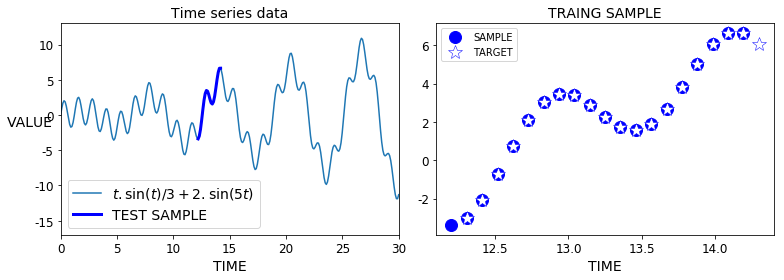

array([[-1.40208096, -2.33035999],
       [-2.33035999, -3.4513234 ],
       [-3.4513234 , -4.52641909],
       [-4.52641909, -5.32081479],
       [-5.32081479, -5.66045846],
       [-5.66045846, -5.47433377],
       [-5.47433377, -4.81157012],
       [-4.81157012, -3.82922233],
       [-3.82922233, -2.75371563],
       [-2.75371563, -1.82539786],
       [-1.82539786, -1.23977629],
       [-1.23977629, -1.0998269 ],
       [-1.0998269 , -1.39105208],
       [-1.39105208, -1.98539218],
       [-1.98539218, -2.67303091],
       [-2.67303091, -3.214304  ],
       [-3.214304  , -3.39899794],
       [-3.39899794, -3.09851497],
       [-3.09851497, -2.29812628],
       [-2.29812628, -1.10140997]])

In [23]:
import numpy as np
import tensorflow as tf

reset_graph()

t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("Time series data", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="TEST SAMPLE")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("TIME")
plt.ylabel("VALUE", rotation=0)

plt.subplot(122)
plt.title("TRAING SAMPLE", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="SAMPLE")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="TARGET")
plt.legend(loc="upper left")
plt.xlabel("TIME")


save_fig("time_series_plot")
plt.show()

X_batch, y_batch = next_batch(1, n_steps)

np.c_[X_batch[0], y_batch[0]]

In [30]:
batch_size = 1 # 50
t_min, t_max = 0, 30
n_steps = 20
resolution = 0.01

print(np.random.rand(batch_size, 1))
print((t_max - t_min - n_steps * resolution))

print(np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution))

[[0.77734108]]
29.8
[[27.62581254]]


In [31]:
np.arange(0., n_steps + 1)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [32]:
np.arange(0., n_steps + 1) * resolution

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [34]:
t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
t0 + np.arange(0., n_steps + 1) * resolution

array([[23.13505588, 23.14505588, 23.15505588, 23.16505588, 23.17505588,
        23.18505588, 23.19505588, 23.20505588, 23.21505588, 23.22505588,
        23.23505588, 23.24505588, 23.25505588, 23.26505588, 23.27505588,
        23.28505588, 23.29505588, 23.30505588, 23.31505588, 23.32505588,
        23.33505588]])

In [37]:
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

Ts = t0 + np.arange(0., n_steps + 1) * resolution
ys = time_series(Ts)
ys

array([[-5.95107677, -6.07153397, -6.19376901, -6.31755724, -6.44266844,
        -6.56886746, -6.69591476, -6.82356702, -6.95157774, -7.07969781,
        -7.20767617, -7.33526042, -7.46219742, -7.58823394, -7.71311726,
        -7.83659582, -7.95841983, -8.07834188, -8.19611755, -8.31150604,
        -8.42427072]])

In [38]:
ys[:, :-1].reshape(-1, n_steps, 1)

array([[[-5.95107677],
        [-6.07153397],
        [-6.19376901],
        [-6.31755724],
        [-6.44266844],
        [-6.56886746],
        [-6.69591476],
        [-6.82356702],
        [-6.95157774],
        [-7.07969781],
        [-7.20767617],
        [-7.33526042],
        [-7.46219742],
        [-7.58823394],
        [-7.71311726],
        [-7.83659582],
        [-7.95841983],
        [-8.07834188],
        [-8.19611755],
        [-8.31150604]]])

In [39]:
ys[:, 1:].reshape(-1, n_steps, 1)

array([[[-6.07153397],
        [-6.19376901],
        [-6.31755724],
        [-6.44266844],
        [-6.56886746],
        [-6.69591476],
        [-6.82356702],
        [-6.95157774],
        [-7.07969781],
        [-7.20767617],
        [-7.33526042],
        [-7.46219742],
        [-7.58823394],
        [-7.71311726],
        [-7.83659582],
        [-7.95841983],
        [-8.07834188],
        [-8.19611755],
        [-8.31150604],
        [-8.42427072]]])

In [40]:
# t
int((t_max - t_min) / resolution)

3000

In [41]:
np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

array([0.00000000e+00, 1.00033344e-02, 2.00066689e-02, ...,
       2.99799933e+01, 2.99899967e+01, 3.00000000e+01])

In [42]:
# t_instance
12.2 + resolution

12.209999999999999

In [43]:
12.2 + resolution * (n_steps + 1)

12.41

In [44]:
np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

array([12.2   , 12.2105, 12.221 , 12.2315, 12.242 , 12.2525, 12.263 ,
       12.2735, 12.284 , 12.2945, 12.305 , 12.3155, 12.326 , 12.3365,
       12.347 , 12.3575, 12.368 , 12.3785, 12.389 , 12.3995, 12.41  ])

- <b><code>OutputProjectionWrapper</code>사용하기</b>
  - RNN의 출력 시퀀스 차원을 타임 스텝마다(그리고 샘플마다) 하나의 값으로 줄인다.
    - [batch_size, timestep_ n_inputs] -> [batch_size, timestep, 1]

In [6]:
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [7]:
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book
    
with tf.Session() as sess:                          # 책에는 없음
    saver.restore(sess, "./my_time_series_model")   # 책에는 없음

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

0 	MSE: 11.9672575
100 	MSE: 0.52584445
200 	MSE: 0.14959829
300 	MSE: 0.07381975
400 	MSE: 0.06171744
500 	MSE: 0.05968452
600 	MSE: 0.055536177
700 	MSE: 0.047983035
800 	MSE: 0.050073363
900 	MSE: 0.04728166
1000 	MSE: 0.047391903
1100 	MSE: 0.048076287
1200 	MSE: 0.040791243
1300 	MSE: 0.0479767
1400 	MSE: 0.04211445
INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [ ]:
y_pred

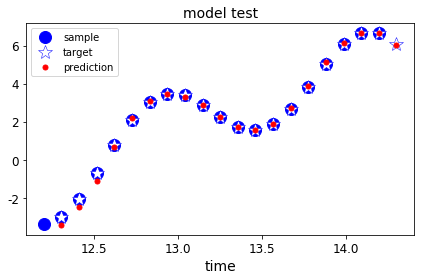

In [12]:
plt.title("model test", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="sample")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("time")

save_fig("time_series_pred_plot")
plt.show()

- <b><code>OutputProjectionWrapper</code> 사용하지 않기</b>

In [25]:
import numpy as np
import tensorflow as tf

reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001

n_iterations = 1500
batch_size = 50

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

                                  #  기존 RNN 출력 형태 [50, 20, 100]
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) # 모든 출력을 차례대로 쌓고 => [1000 (=50*20), 100]
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # 완전 여결 선형 층을 적용하고 (차원만 축소) => [1000, 1]
                                  #   [1000 , 100]          1
                                  #  tf.layers.dense는 densely-connected layer, '완전연결계층'을 만들어줌
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) # 모든 출력을 원래 차원으로 되돌림 => [50, 20, 1]

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907031
100 	MSE: 0.5056713
200 	MSE: 0.20992868
300 	MSE: 0.10282391
400 	MSE: 0.06876178
500 	MSE: 0.061076507
600 	MSE: 0.054797072
700 	MSE: 0.04966834
800 	MSE: 0.050121456
900 	MSE: 0.047807403
1000 	MSE: 0.04775478
1100 	MSE: 0.050040428
1200 	MSE: 0.041216638
1300 	MSE: 0.05031095
1400 	MSE: 0.04354385


In [26]:
y_pred

array([[[-3.4392304 ],
        [-2.4754486 ],
        [-1.1431999 ],
        [ 0.67572594],
        [ 2.2022252 ],
        [ 3.0979629 ],
        [ 3.4667068 ],
        [ 3.317198  ],
        [ 2.856221  ],
        [ 2.2434225 ],
        [ 1.7069325 ],
        [ 1.5460964 ],
        [ 1.8807409 ],
        [ 2.7058399 ],
        [ 3.893656  ],
        [ 5.112901  ],
        [ 6.1083117 ],
        [ 6.658971  ],
        [ 6.645973  ],
        [ 6.051144  ]]], dtype=float32)

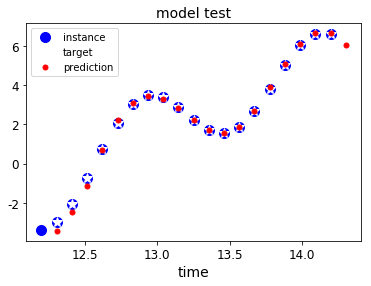

In [27]:
plt.title("model test", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("time")

plt.show()

<img src="./img/chap14-1/img/29.png" width="50%">

- <b>새로운 시퀀스 생성하기</b>

INFO:tensorflow:Restoring parameters from ./my_time_series_model


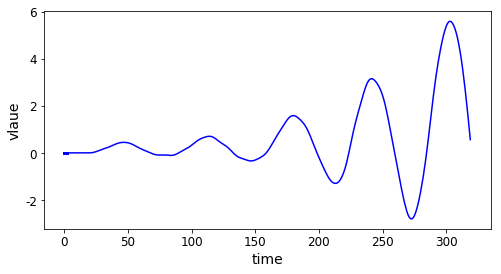

In [59]:
with tf.Session() as sess:                        # 책에는 없음
    saver.restore(sess, "./my_time_series_model") # 책에는 없음

    sequence = [0.] * n_steps  # n_steps 값을 가지는 시드 시퀀스 (0으로 채워진 시퀀스)
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)  # 반대로 정령하고, 입력 shpqe에 맞게 변환
        y_pred = sess.run(outputs, feed_dict={X: X_batch})              # 다음 값 예측
        sequence.append(y_pred[0, -1, 0])                               # 에측한 값을 시퀀스에 추가
        
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("time")
plt.ylabel("vlaue")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model


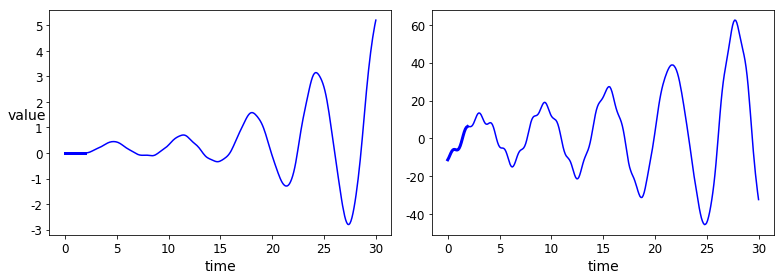

In [34]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("time")
plt.ylabel("value", rotation=0)

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("time")
save_fig("creative_sequence_plot")
plt.show()

## 14.4 심층 RNN
- 셀을 여러 층으로 쌓는 것
<img src="./img/chap14-1/img/28.png" width="50%">

1. RNN 셀 생성
2. MultiRNNCell을 이용
  - 생성한 RNN 셀들을 리스트로 묶어서 <code>tf.contrib.rnn.MultiRNNCell()</code> 함수의 인자로 넣어준다.
3. <code>static_rnn</code> 또는 <code>dynamic_rnn</code> 구조를 정의

In [79]:
import numpy as np
import tensorflow as tf

reset_graph()

n_batches = 10
n_steps = 5
n_inputs = 2

# 14.2.2 동적으로 타임 스텝 펼치기 -dynamic_rnn에서와 유사
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(cell=multi_layer_cell, 
                                    inputs=X, 
                                    dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.random.rand(n_batches, n_steps, n_inputs)

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [80]:
# [batch_size, max_timestep, n_neurons]
print("shape of outputs_val:\n{}\n\n".format(outputs_val.shape))

shape of outputs_val:
(10, 5, 100)




In [81]:
# states변수는 총 세 개의 층을 갖음
print("length of states_val: {}\n\n".format(len(states_val)))

length of states_val: 3




In [82]:
# states변수는 층 마다 [batch_size, n_neurons] 크기의 하나의 텐서가 들어 있는 튜플
print("type of states_val: {}\n\n".format(type(states_val))) 

type of states_val: <class 'tuple'>




In [83]:
# 셀의 마지막 상태는 [batch_size, n_neurons]의 크기를 갖음
print("shape of states_val: {}\n\n".format(np.array((states_val[0])).shape))
# print("states_val[0]: {}\n\n".format((states_val[0])))

shape of states_val: (10, 100)




In [84]:
print("states_val: \n{}\n\n".format(states_val)) 

states_val: 
(array([[-4.20370579e-01,  2.11737394e-01,  1.06719553e-01,
         1.73230469e-01,  1.60681695e-01,  6.10057227e-02,
         2.93204010e-01, -5.28066643e-02,  1.13277651e-01,
         3.66319157e-02,  1.61643431e-01,  1.64362133e-01,
        -9.35909227e-02,  3.01763475e-01,  2.75812805e-01,
         2.82845050e-01,  1.13793492e-01,  3.51762921e-01,
        -1.01236016e-01, -2.38568574e-01, -3.11844796e-01,
         1.34004042e-01, -7.07619414e-02, -2.14003474e-01,
         2.47512802e-01,  1.70731738e-01,  1.95899799e-01,
        -2.07845327e-02, -2.54524589e-01,  1.63491845e-01,
         1.74647883e-01,  8.36870447e-02,  2.82777816e-01,
        -2.55383730e-01,  1.19310357e-01,  2.07206737e-02,
         3.02020818e-01,  4.66213860e-02,  1.47858420e-02,
         4.17839736e-02,  3.12906981e-01,  1.16583429e-01,
        -3.59985352e-01, -1.32687077e-01,  2.05680773e-01,
        -2.61917055e-01,  7.60082230e-02,  3.35944593e-01,
         1.73105076e-01, -1.00370005e-01, 

### 14.4.1 여러 GPU에 심층 RNN 분산하기

- <code> with tf.device("/gpu:0"): ... </code>와 같은 방식으로 <code>BasicRNNCell</code>을 이용한 RNN 셀 만들기는 불가
  - <code>BasicRNNCell</code>은 셀 자체가 아닌 셀 팩토리이기 때문에, <code>BasicRNNCell</code>을 호출한다 해도 실제로는 어떠한 셀도 실제로 생성되지 않기 때문
  - 실제 셀은 나중에 생성된다; <code>dynamic_rnn()</code> 호출 -> <code>MultiRNNCell()</code> 호출 -> <code>BasicRNNCell()</code> 호출 -> 셀과 변수 생성
- 직접 셀 Wrapper를 만들어서 해결하거나, <code>tf.contrib.rnn.DeviceWrapper()</code>를 이용하여 해결

<code>
ssh -P 22222 218.150.183.224
ssh 192.168.1.3
cd hands-on-ml-14
python 14.4.1-1.py
python 14.4.1-2.py
</code>

- <b>직접 셀 Wrapper를 만들어 해결하는 방법</b>

In [3]:
import tensorflow as tf
import numpy as np

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._cell.output_size

    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope)

reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

# devices = ["/gpu:0", "/gpu:1"]
devices = ["/cpu:0", "/cpu:0"]

cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
[[[ 0.12814313 -0.06190126 -0.01219105 ...  0.11745725 -0.06391355
   -0.03536093]
  [ 0.18934107  0.2197493  -0.08168206 ...  0.01110621  0.02297783
   -0.14687203]
  [ 0.2568374  -0.09154218 -0.13794416 ... -0.10892123 -0.23443538
    0.19420108]
  ...
  [ 0.3860678   0.4474522   0.00543183 ... -0.31153482 -0.03611771
    0.48814902]
  [ 0.44772214  0.44482473 -0.14211331 ... -0.4731552  -0.25904474
    0.34857288]
  [ 0.38244483  0.1800263   0.13623148 ... -0.4662782  -0.08823261
    0.46203986]]

 [[ 0.05981907  0.05408838  0.05066916 ...  0.18492858 -

- <b><code>tf.contrib.rnn.DeviceWrapper()</code>를 이용하여 해결하는 방법</b>

In [5]:
import tensorflow as tf
import numpy as np

reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

# devices = ["/gpu:0", "/gpu:1"]
devices = ["/cpu:0", "/cpu:0"]

cells = [tf.contrib.rnn.DeviceWrapper(cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons), device=dev)
        for dev in devices]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[ 0.12814313 -0.06190126 -0.01219105 ...  0.11745725 -0.06391355
   -0.03536093]
  [ 0.18934107  0.2197493  -0.08168206 ...  0.01110621  0.02297783
   -0.14687203]
  [ 0.2568374  -0.09154218 -0.13794416 ... -0.10892123 -0.23443538
    0.19420108]
  ...
  [ 0.3860678   0.4474522   0.00543183 ... -0.31153482 -0.03611771
    0.48814902]
  [ 0.44772214  0.44482473 -0.14211331 ... -0.4731552  -0.25904474
    0.34857288]
  [ 0.38244483  0.1800263   0.13623148 ... -0.4662782  -0.08823261
    0.46203986]]

 [[ 0.05981907  0.05408838  0.05066916 ...  0.18492858 -0.03955491
   -0.10670385]
  [ 0.24289732  0.01772532 -0.13251695 ...  0.05404707 -0.03705034
    0.01263875]
  [ 0.35057187 -0.04662552 -0.09477387 ...  0.04283168  0.08205313
   -0.04917469]
  ...
  [ 0.30997375  0.2823197   0.39413193 ... -0.2845239  -0.12873316
    0.4872231 ]
  [ 0.66408616  0.38888997  0.2260942  ... -0.6228083  -0.31918454
    0.36147064]
  [ 0.5175864   0.48620206  0.19067784 ... -0.52175856 -0.1661249
    0.4

### 14.4.2 드롭아웃 적용하기
- 여러 층의 셀을 쌓는 과정
<code>
1.RNN 셀 생성
2.MultiRNNCell을 이용
  - 생성한 RNN 셀들을 리스트로 묶어서 <code>tf.contrib.rnn.MultiRNNCell()</code> 함수의 인자로 넣어준다.
3.<code>static_rnn</code> 또는 <code>dynamic_rnn</code> 구조를 정의
</code>
<br>

- 깊은 RNN -> 과대적합 유도 -> Dropout 적용하여 해결
- <code>tf.contrib.rnn.DropoutWrapper()</code>를 이용

- 
<code>
1.RNN 셀 생성
<b>2.dropout_rate을 정하여 BasicRNNCell과 함께 <code>tf.contrib.rnn.DropoutWrapper()</code>의 인자로 넘겨준다.</b>
3.MultiRNNCell을 이용
  - 생성한 RNN 셀들을 리스트로 묶어서 <code>tf.contrib.rnn.MultiRNNCell()</code> 함수의 인자로 넣어준다.
4.<code>static_rnn</code> 또는 <code>dynamic_rnn</code> 구조를 정의
</code>

In [60]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

0 훈련 MSE: 16.328941
100 훈련 MSE: 4.663095
200 훈련 MSE: 3.1909423
300 훈련 MSE: 3.7488384
400 훈련 MSE: 2.7756567
500 훈련 MSE: 3.3540435
600 훈련 MSE: 3.1500022
700 훈련 MSE: 3.8468375
800 훈련 MSE: 4.054598
900 훈련 MSE: 4.195963
1000 훈련 MSE: 3.3322837
1100 훈련 MSE: 3.6828902
1200 훈련 MSE: 2.9549835
1300 훈련 MSE: 2.7623703
1400 훈련 MSE: 3.4052289
INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


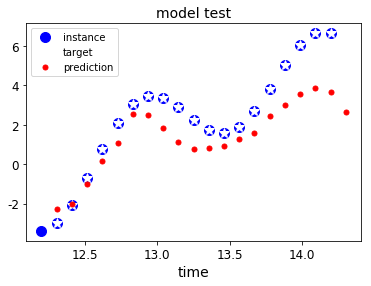

In [61]:
import tensorflow as tf
import numpy as np

reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

keep_prob = tf.placeholder_with_default(1.0, shape=()) 

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]

# input_keep_prob: input에 대한 dropout_rate. 0-1 사이의 값. 
# if it is constant and 1, no input dropout will be added.
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 1500 # 1500 번의 반복
batch_size = 50
train_keep_prob = 0.5 

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "훈련 MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")
    
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
plt.title("model test", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("time")

plt.show()

### RNN's Problem
- Long-Term Dependency
  - 현재 state와 과거 input과의 term이 길 때 input을 반영하지 못하는 현상
<img src="./img/chap14-1/img/25.png" width="50%">
<img src="./img/chap14-1/img/26.gif" width="80%">

### 참고문헌(Reference)
- A. Géron, "Hands on Machine Learning with Scikit-learn and TensorFlow"
- https://nbviewer.jupyter.org/github/rickiepark/handson-ml/blob/master/14_recurrent_neural_networks.ipynb
- Performance RNN: Generating Music with Expressive Timing and Dynamics, Magenta Blog, 2017, https://goo.gl/HelqAh
- https://github.com/tensorflow/magenta/blob/master/README.md
- https://cdn2.vox-cdn.com/uploads/chorus_asset/file/6577761/Google_-_Magenta_music_sample.0.mp3
- O. Vinylas, A. Toshev, S. Bengio and D. Erhan, "Show and Tell: A Neural Image Caption Generator," arXiv:1411.4555v2 [cs.CV], 20, Apr, 2015.
- D.-H. Kwon, J.-B. Kim, J.-S. Heo, C.-M. Kim and Y.-H. Han, "Time Series Classification of Cryptocurrency Price Trend Based on a Recurrent LSTM Neural Network," Journal of Information Processing Systems.
- V. Pham, T. Bluche, C. Kermorvant and J. Louradour, "Dropout improves Recurrent Neural Networks for Handwriting Recognition," arXiv:1312.4569v2 [cs.CV]. 10. Mar. 2014.
- https://aikorea.org/blog/rnn-tutorial-3/
- https://www.reddit.com/r/MachineLearning/comments/9elxs8/d_why_do_you_use_tanh_in_a_rnn/
- https://medium.com/mlrecipies/recurrent-neural-networks-theory-f81d59c2add7
- 조태호, "모두의 딥러닝"
- 타테이시 켄고, "기초 수학으로 이해하는 머신러닝 알고리즘"
- https://maclab-kaist.github.io/DeepArt/melody_rnn/MelodyRNN_03_Tensorflow_Basic_RNN_model.html
- https://excelsior-cjh.tistory.com/183
- 톰 호프, 예헤즈켈 레셰프, 이타이 리더, "러닝 텐서플로: 딥러닝 영상처리와 NLP부터 텐서보드 시각화, 멀티스레딩, 분산처리까지"
- tanh: https://keisan.casio.com/exec/system/15411343653769
- http://link.koreatech.ac.kr/?page_id=3204
- rank 관련: https://bcho.tistory.com/1153
- tf.stack, tf.unstack관련: https://www.dotnetperls.com/stack-tensorflow
- tf.nn.dynamic_rnn()의 swap_memory 옵션: https://stackoverflow.com/questions/44049192/swap-memory-in-dynamic-rnn-allows-quasi-infinite-sequences
- tf.nn.dynamic_rnn(): https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/ops/rnn.py
- gradient vanishing: http://people.idsia.ch/~juergen/fundamentaldeeplearningproblem.html
- https://aikorea.org/blog/rnn-tutorial-3/
- BPTT, vanishing gradient: https://skymind.ai/kr/wiki/lstm#backpropagation
- Long-Term Dependecies: https://nbviewer.jupyter.org/format/slides/gist/leechanwoo/d5fbd038ad6c7242efbfeeb87d1f740b#/9
- Truncated BPTT: https://github.com/nmhkahn/deep_learning_tutorial/blob/master/slides/RNN.pdf
- MultiRNNCell: https://kakalabblog.wordpress.com/2017/06/23/implementing-rnn-in-tensorflow/
- tf.nn.in_top_k: https://yujuwon.tistory.com/entry/TENSORFLOW-TensorFlow-Mechanics-101

# etc

In [1]:
# import tensorflow and numpy
import tensorflow as tf
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


# array for alphabet
char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']


# assign array index to each alphabet
# ex: 'a': 0, 'b': 1, 'c': 2  ...
num_dic = {n: i for i, n in enumerate(char_arr)}


# training words and constants
seq_data = ['body', 'dial', 'open', 'rank', 'need', 'wise', 'item', 'jury', 'path', 'ease']
n_input = n_class = 26
n_stage = 3 


# input encoder
def make_batch(seq_data):
    input_batch = []
    target_batch = []

    for seq in seq_data:
        input = [num_dic[n] for n in seq[0:3]]
        target = num_dic[seq[-1]]
        input_batch.append(np.eye(26)[input])
        target_batch.append(target)
    return input_batch, target_batch


# global parameters
learning_rate = 0.01
n_hidden = 128
total_epoch = 100


# placeholders and variables
# the input placeolder should be 3-dimensional 
# in order to use tensorflow RNN cells
# note that Y, output label, is 1-dimensional
X = tf.placeholder(tf.float32, [None, n_stage, n_input])
Y = tf.placeholder(tf.int32, [None])
W = tf.Variable(tf.random_normal([n_hidden, n_class]))
b = tf.Variable(tf.random_normal([n_class]))


# two RNN cells and their deep RNN network
# we use dropout in cell 1
cell1 = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
# cell1 = tf.nn.rnn_cell.LSTMCell(n_hidden)
cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=0.5)
cell2 = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
# cell2 = tf.nn.rnn_cell.LSTMCell(n_hidden)

multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)


# RNN output re-ordering and trimming in 3 steps
# [batch_size, n_stage, n_hidden] ->
# [n_stage, batch_size, n_hidden] ->
# [batch_size, n_hidden] 
# this cases the last stage output to be used
# model produces 26 floating point values
# prediction uses argmax to find which index model computes
outputs = tf.transpose(outputs, [1, 0, 2])
outputs = outputs[-1]
model = tf.matmul(outputs, W) + b
prediction = tf.cast(tf.argmax(model, 1), tf.int32)


# prints model and prediction information
def info():
    sample = ['body']
    input_batch, target_batch = make_batch(sample)
    m_info, p_info = sess.run([model, prediction], feed_dict={X: input_batch, Y: target_batch})

    print('word:', sample)
    print('model:', m_info)
    print('prediction:', p_info)
    print('predicted character', char_arr[p_info[0]])
    print()


# loss function and optimizer
# this new tool better handles 1-dimensional label
# note the difference in size between logits and labels
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


# testing the given set of words
def test(words):
    input_batch, target_batch = make_batch(words)
    guess = sess.run(prediction, feed_dict={X: input_batch, Y: target_batch})

    for i, seq in enumerate(words):
        print(seq[0:3], char_arr[guess[i]])
    print()


# session and main flow
sess = tf.Session()
sess.run(tf.global_variables_initializer())

test(seq_data)
input_batch, target_batch = make_batch(seq_data)
for epoch in range(total_epoch):
    _, error = sess.run([optimizer, loss], feed_dict={X: input_batch, Y: target_batch})
    print('epoch: %04d' % epoch, 'error = %.4f' % error)

print()
info()
test(seq_data)
seq_data = ['bod', 'bad', 'boe', 'nar', 'nef', 'zzz']
test(seq_data)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
bod t
dia g
ope x
ran a
nee c
wis t
ite o
jur u
pat m
eas b

epoch: 0000 error = 5.9403
epoch: 0001 error = 0.2371
epoch: 0002 error = 0.0056
epoch: 0003 error = 0.0002
epoch: 0004 error = 0.0001
epoch: 0005 error = 0.1574
epoch: 0006 error = 0.0000
epoch: 0007 error = 0.0000
epoch: 0008 error = 0.0016
epoch: 0009 error = 0.0151
epoch: 0010 error = 0.0005
epoch: 0011 error = 0.2623
epoch: 0012 error = 0.0015
epoch: 0013 error = 0.1722
epoch: 0

In [1]:
# import related packages
import tensorflow as tf
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


# 41 characters used in the dictionary
# S, E, and P are special characters used in RNN
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz단어나무놀이소녀파란사랑']
num_dic = {n: i for i, n in enumerate(char_arr)}
dic_len = len(num_dic)
n_class = n_input = dic_len


# training data
# the english word should be of length 4, and the korean 2
seq_data = [['word', '단어'], ['wood', '나무'], ['game', '놀이'], ['girl', '소녀'], ['blue', '파란'], ['love', '사랑']]


# one-hot encoding function
def make_batch(seq_data):
    input_batch = []
    output_batch = []
    target_batch = []

    for seq in seq_data:
        input = [num_dic[n] for n in seq[0]]
        output = [num_dic[n] for n in ('S' + seq[1])]
        target = [num_dic[n] for n in (seq[1] + 'E')]

        input_batch.append(np.eye(dic_len)[input])
        output_batch.append(np.eye(dic_len)[output])
        target_batch.append(target)

    return input_batch, output_batch, target_batch


# global parameters
learning_rate = 0.01
n_hidden = 128
total_epoch = 100


# in Seq2Seq RNN, we use the following placeholder type
# for the encoder and decoder:
# [batch size, time steps, input size]
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])


# in Seq2Seq RNN, we use the following placeholder type
# for the output: [batch size, time steps]
targets = tf.placeholder(tf.int64, [None, None])


# encoder cell definition
# we use dropout to avoid overfitting
with tf.variable_scope('encode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
#     enc_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)
    _ , enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32)


# decoder cell definition
# we use dropout to avoid overfitting
with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
#     dec_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

    # in Seq2Seq model, we use the encoder output state
    # as the initial state for the decoder
    dec_outputs, _ = tf.nn.dynamic_rnn(dec_cell, dec_input, initial_state=enc_states, dtype=tf.float32)


# instead of tf.matmul(outputs, W)+b, 
# we use the 'dense' function in tensorflow layers:
# 'dense' produces [batch_size, time_step, input_size]
# in our case, model shape is (?, ?, 41)
model = tf.layers.dense(dec_outputs, n_class, activation=None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# print model and target information
def info():
    sample = [['word', '단어']]
    input_batch, output_batch, target_batch = make_batch(sample)
    m_info, t_info = sess.run([model, targets], feed_dict = {enc_input: input_batch, 
        dec_input: output_batch, targets: target_batch})

    print('input:', sample)
    print('model\n', m_info)
    print('target:', t_info)
    print()


# training session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
input_batch, output_batch, target_batch = make_batch(seq_data)

for epoch in range(total_epoch):
    _, loss = sess.run([opt, cost], feed_dict={enc_input: input_batch, dec_input: output_batch, 
        targets: target_batch})
    print('epoch: %04d' % epoch, 'cost: %.4f' % loss)

info()


# test new words
new_data = [['word', 'PP'], ['wodr', 'PP'], ['love', 'PP'], ['loev', 'PP'], ['abcd', 'PP'], 
    ['wide', 'PP'], ['gate', 'PP'], ['blue', 'PP'], ['glue', 'PP']]
input_batch, output_batch, target_batch = make_batch(new_data)
prediction = tf.argmax(model, 2)
result = sess.run(prediction, feed_dict = {enc_input: input_batch, dec_input: output_batch, 
    targets: target_batch})

for i in range(len(new_data)):
    decoded = [char_arr[i] for i in result[i]]
    korean = decoded[0] + decoded[1]
    print('english:', new_data[i][0], ', result:', result[i], ', korean:', korean)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
epoch: 0000 cost: 3.7059
epoch: 0001 cost: 3.5811
epoch: 0002 cost: 3.3693
epoch: 0003 cost: 2.9550
epoch: 0004 cost: 2.2473
epoch: 0005 cost: 2.3476
epoch: 0006 cost: 1.9763
epoch: 0007 cost: 1.8824
epoch: 0008 cost: 1.8493
epoch: 0009 cost: 1.6042
epoch: 0010 cost: 1.4295
epoch: 0011 cost: 1.1157
epoch: 0012 cost: 1.1888
epoch: 0013 cost: 0.9457
epoch: 0014 cost: 0.7449
epoch: 0015 cost: 0.9592
epoch: 0016 cost: 0.6462
epoch: 0017 cost: 0.7679
epoch: 0018 cost: 0.4616
epoch: 0019 cost: 0.3447
epoch: 0020 cost: 0.6794
epoc